### Voting Classifier

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

def data_split(df):
    missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[missing_cols] = df[missing_cols].replace(0, np.nan)

    for col in missing_cols:
        medians = df.groupby('Outcome')[col].median()
        df[col] = df.apply(lambda row: medians[row['Outcome']] if pd.isna(row[col]) else row[col], axis=1)

    X = df.drop("Outcome", axis=1)
    y = df["Outcome"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    smt = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test

def data_scaling(train_x, test_x):
    scaler = MinMaxScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    return train_x_scaled, test_x_scaled

In [ ]:
df=pd.read_csv('diabetes.csv')

In [ ]:
def voting_model(df, rf,xgb,k, size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

    voting_clf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')

    voting_clf.fit(train_x_scaled, train_y)

    test_y_pred = voting_clf.predict(test_x_scaled)

    print("Training Accuracy:", voting_clf.score(train_x_scaled, train_y))

    print("Testing Accuracy:", voting_clf.score(test_x_scaled, test_y))

    pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)

    return voting_clf, train_x_scaled, test_x_scaled, train_y, test_y

Training Accuracy: 0.9987373737373737
Testing Accuracy: 0.8701298701298701


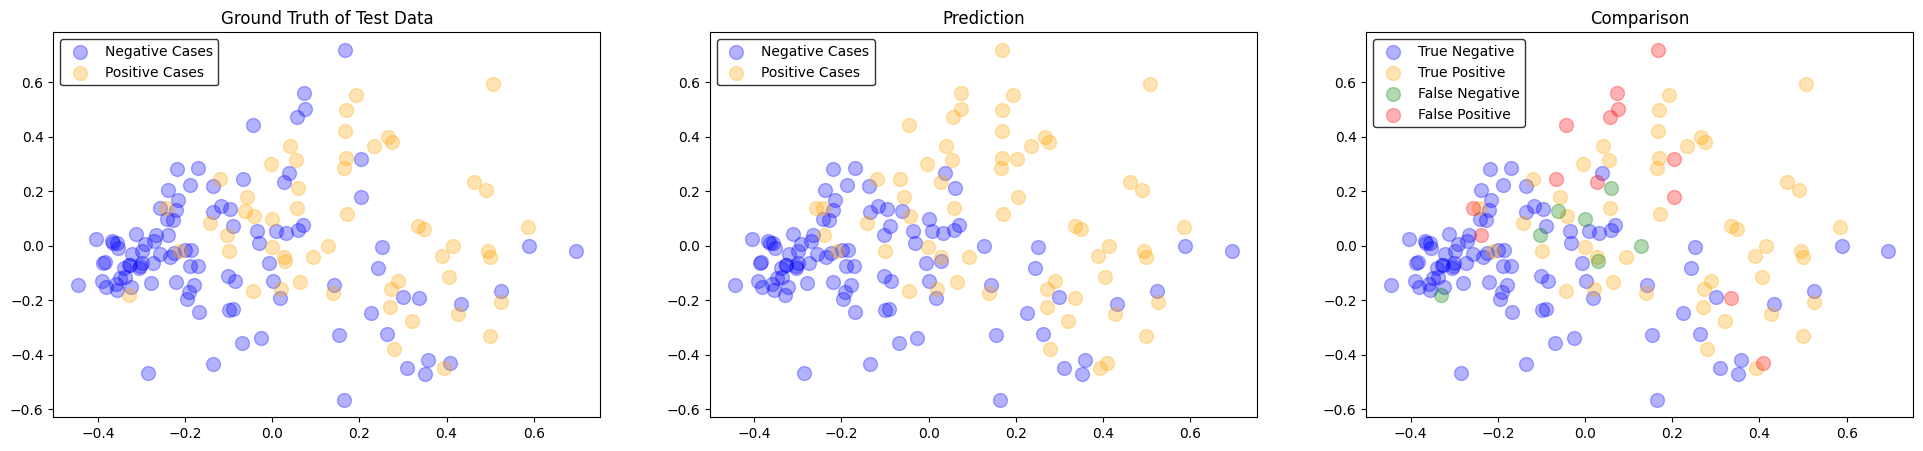

In [ ]:
voting_clf, train_x_scaled, test_x_scaled, train_y, test_y = voting_model(df,forest,xgboost, 5, 100, 1)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
  training_data=train_x_scaled,
  feature_names=X.columns,
  class_names=["Class 0", "Class 1"],
  mode='classification'
)
exp = explainer.explain_instance(
    data_row=test_x_scaled[0],
    predict_fn=voting_clf.predict_proba
)

exp.show_in_notebook()

In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
fn = X.columns
explainer = shap.KernelExplainer(voting_clf.predict_proba, train_x_scaled)
shap_values = explainer.shap_values(test_x_scaled)


  0%|          | 0/154 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

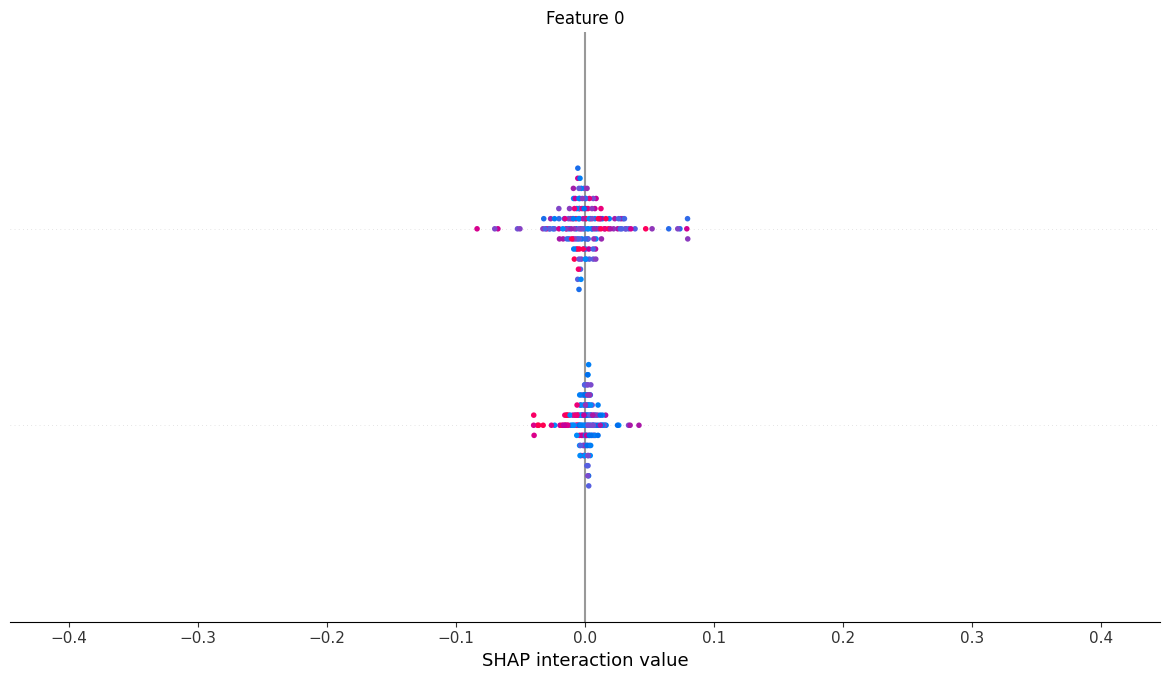

In [ ]:
shap.summary_plot(shap_values, test_x_scaled, color_bar=True)

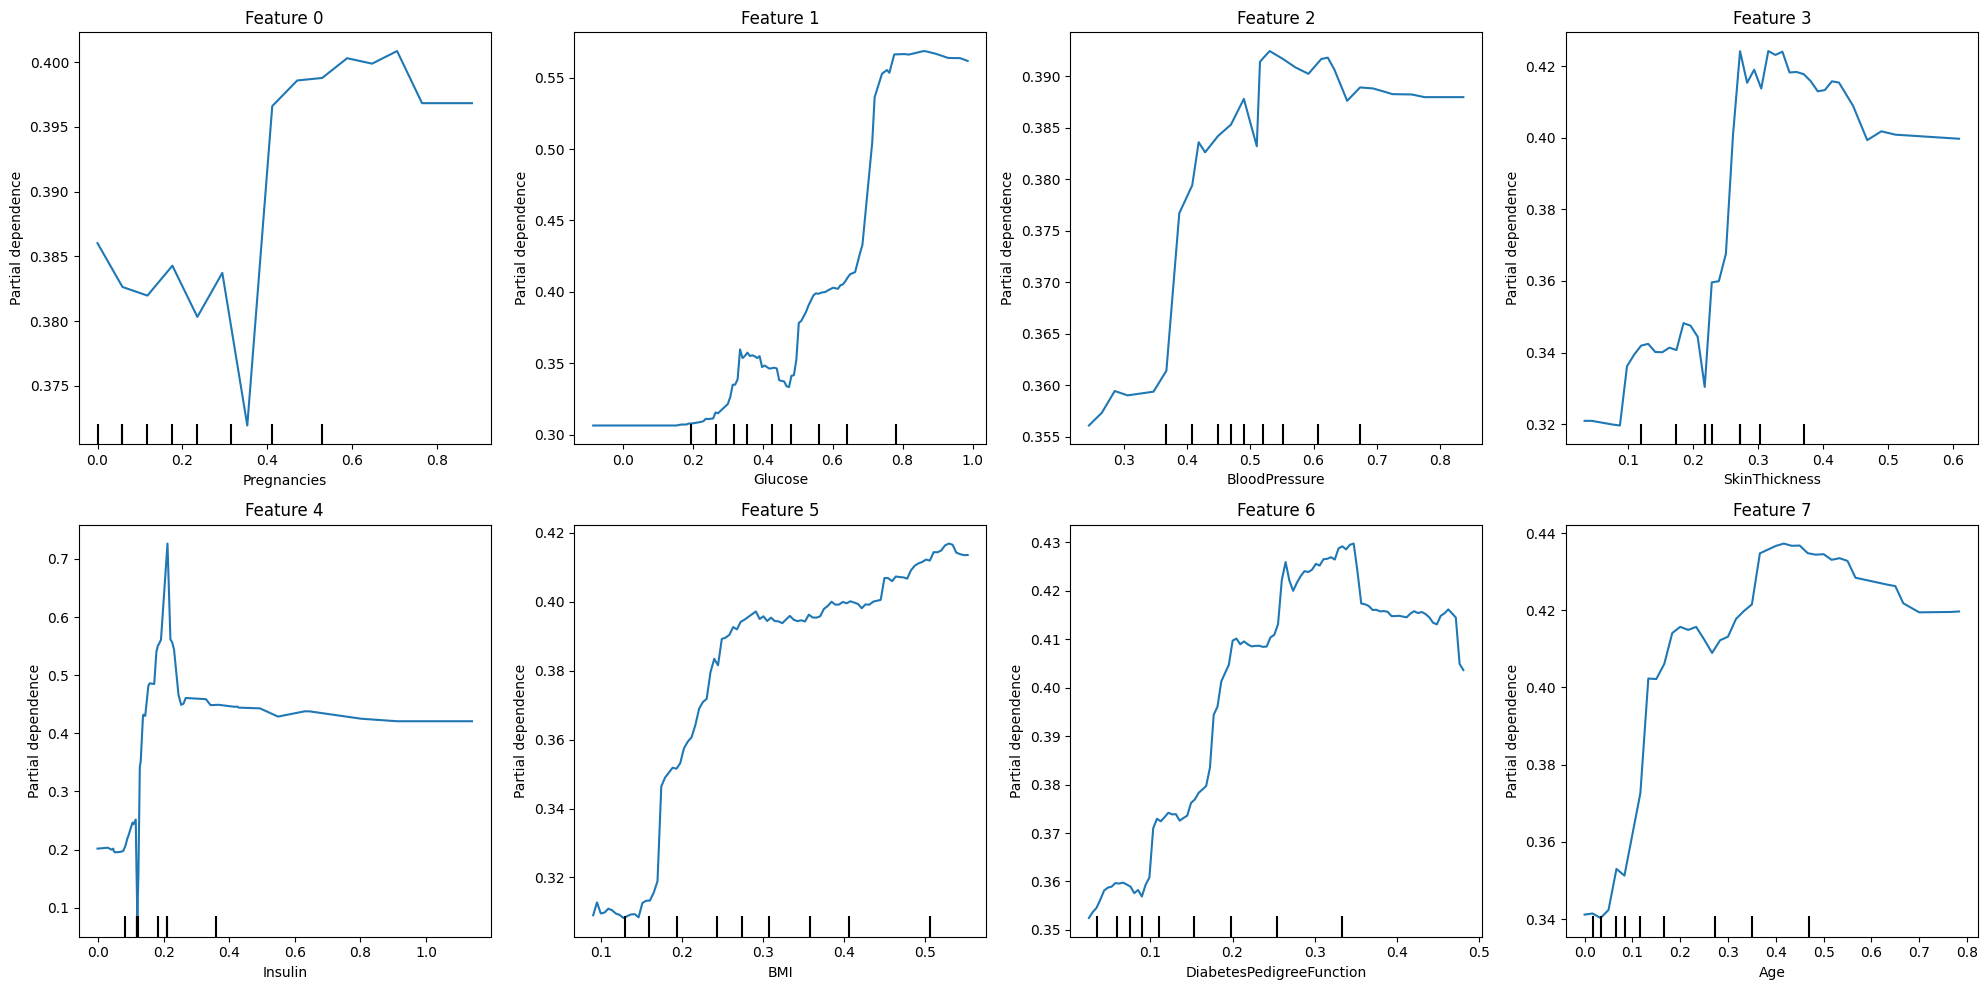

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i in range(X.shape[1]):
  feature = [i]
  target_class = 0
  PartialDependenceDisplay.from_estimator(voting_clf, test_x_scaled, features=feature,feature_names=X.columns,  target=target_class, ax=axes[i])
  axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

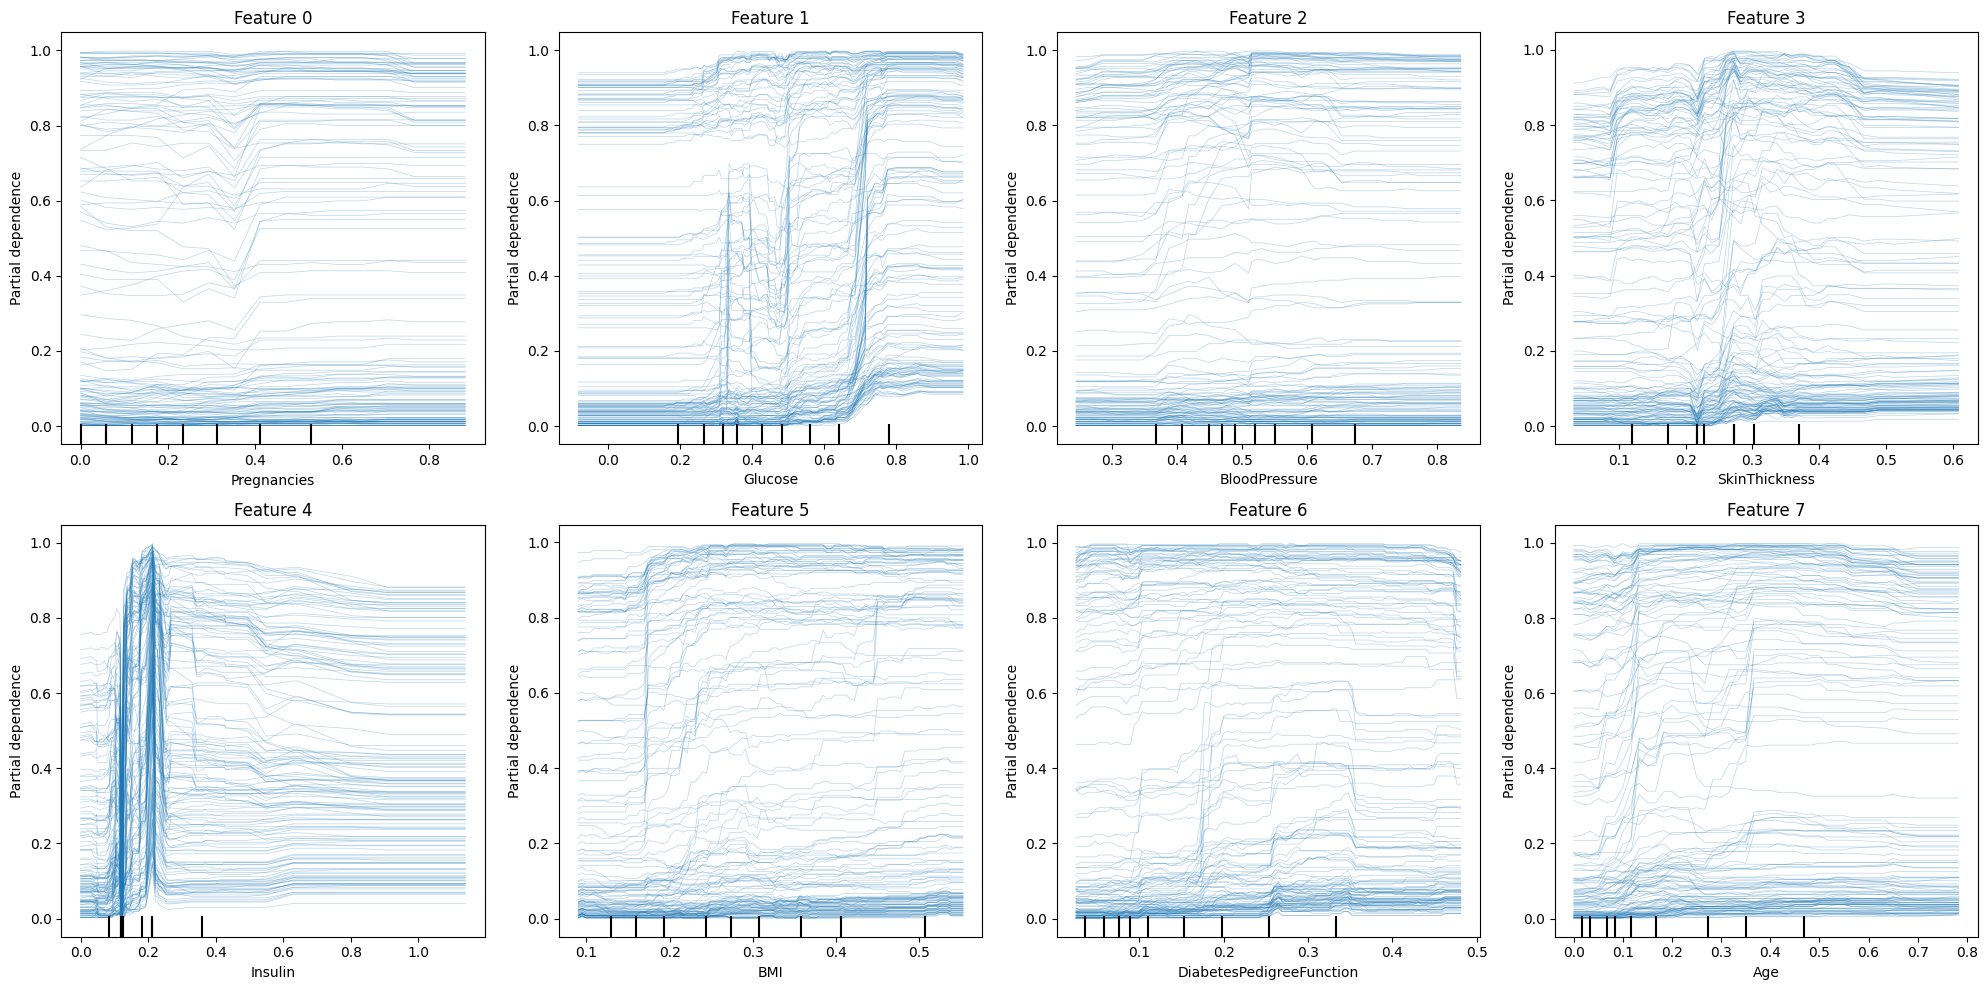

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i in range(X.shape[1]):
  feature = [i]
  target_class = 0
  PartialDependenceDisplay.from_estimator(voting_clf, test_x_scaled, features=feature,feature_names=X.columns, target=target_class, kind='individual', ax=axes[i])
  axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

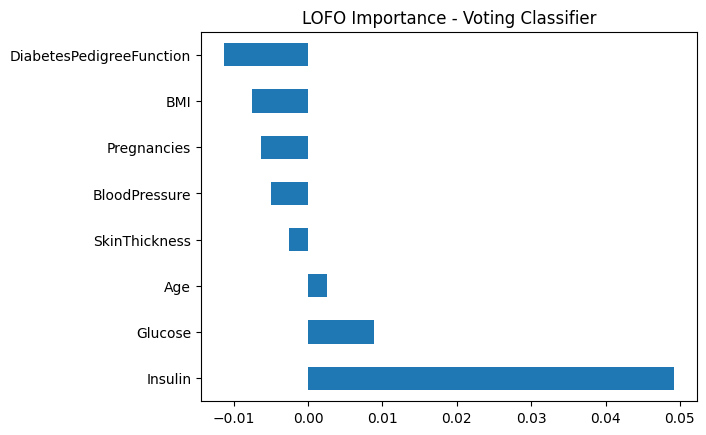

In [ ]:
train_x_scaled_df = pd.DataFrame(train_x_scaled, columns=X.columns)
baseline = cross_val_score(voting_clf, train_x_scaled, train_y, cv=5).mean()

lofo_scores = {}
for col in X.columns:
    X_lofo = train_x_scaled_df.drop(columns=[col])
    score = cross_val_score(voting_clf, X_lofo, train_y, cv=5).mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - Voting Classifier")
plt.show()

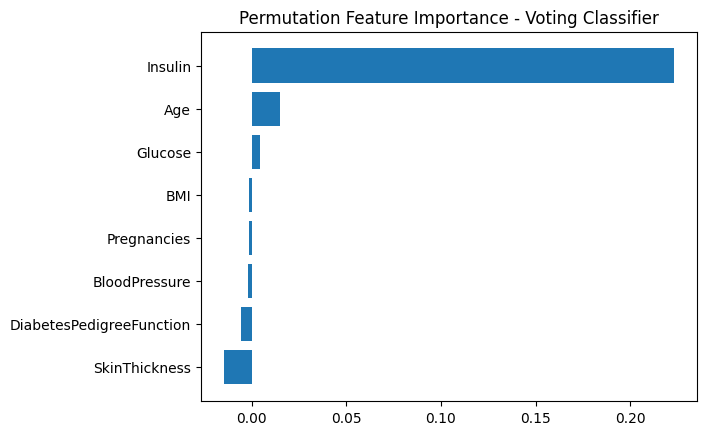

In [ ]:
result = permutation_importance(voting_clf, test_x_scaled, test_y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - Voting Classifier")
plt.show()

# The following model is a bonus if there is any another model is not accepted

### Adaboost

In [ ]:
def adaboost_cv(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  mdl = AdaBoostClassifier()

  cv_result = cross_validate(mdl, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])

  mdl.fit(train_x_scaled, train_y)

  test_y_pred = mdl.predict(test_x_scaled)


  print("Training Accuracy:", mdl.score(train_x_scaled, train_y))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", mdl.score(test_x_scaled, test_y))

  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)
  return mdl, train_x_scaled, test_x_scaled, train_y, test_y

Training Accuracy: 0.9002525252525253
CV Training Accuracy: 0.9081480706265792
Validation Score 0.8826128492954382
Testing Accuracy: 0.8636363636363636


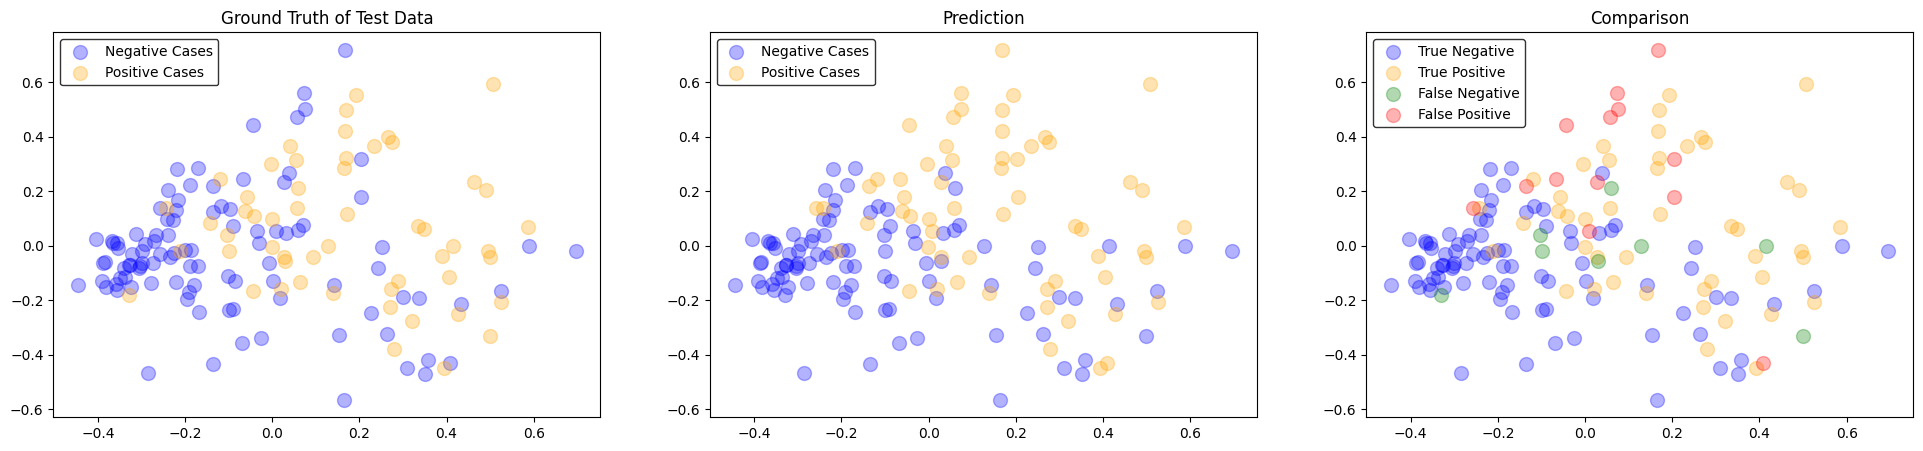

In [ ]:
adaboost, train_x_scaled, test_x_scaled, train_y, test_y = adaboost_cv(df, 5, 100, 1)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
  training_data=train_x_scaled,
  feature_names=X.columns,
  class_names=["Class 0", "Class 1"],
  mode='classification'
)
exp = explainer.explain_instance(
    data_row=test_x_scaled[0],
    predict_fn=adaboost.predict_proba
)

exp.show_in_notebook()

In [ ]:
train_x_scaled_df = pd.DataFrame(train_x_scaled, columns=X.columns)
test_x_scaled_df = pd.DataFrame(test_x_scaled, columns=X.columns)

background = shap.sample(train_x_scaled_df, 100)

explainer = shap.KernelExplainer(adaboost.predict_proba, background)

shap_values = explainer.shap_values(test_x_scaled_df)

  0%|          | 0/154 [00:00<?, ?it/s]

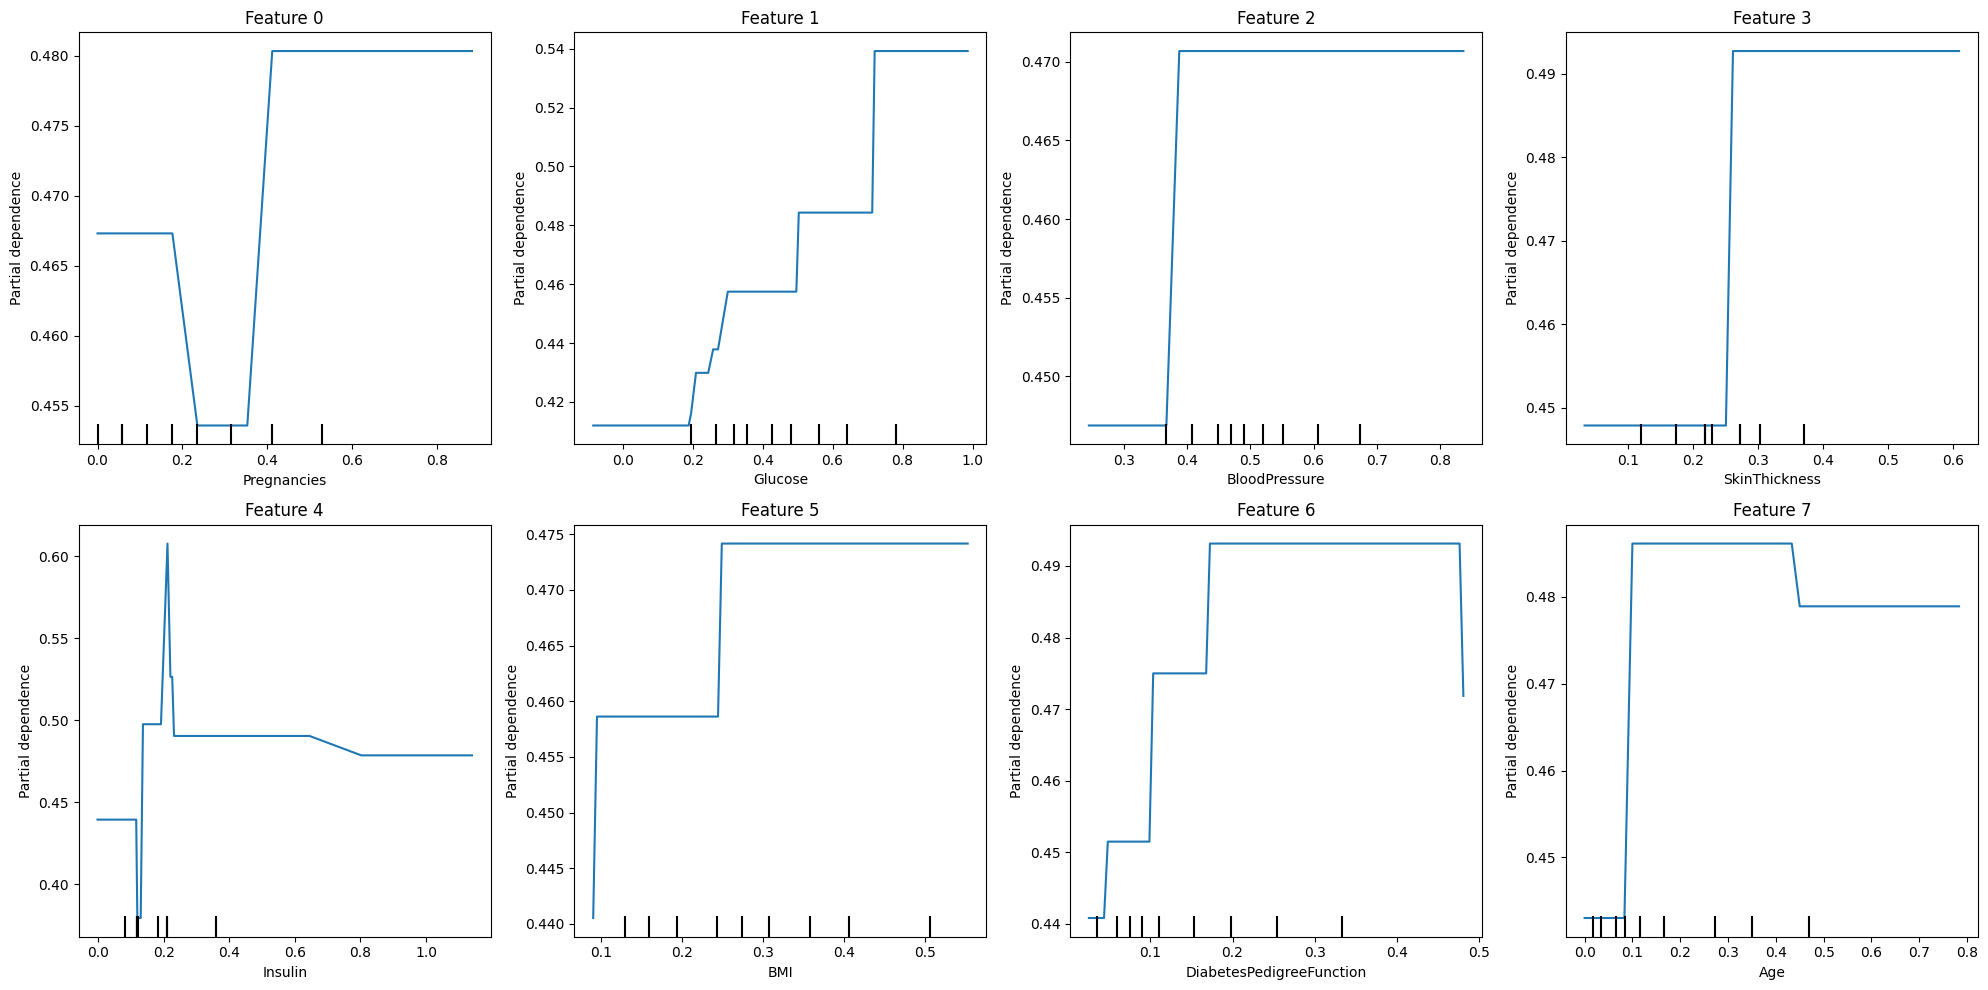

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i in range(X.shape[1]):
  feature = [i]
  target_class = 0
  PartialDependenceDisplay.from_estimator(adaboost, test_x_scaled, features=feature,feature_names=X.columns, target=target_class, ax=axes[i])
  axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

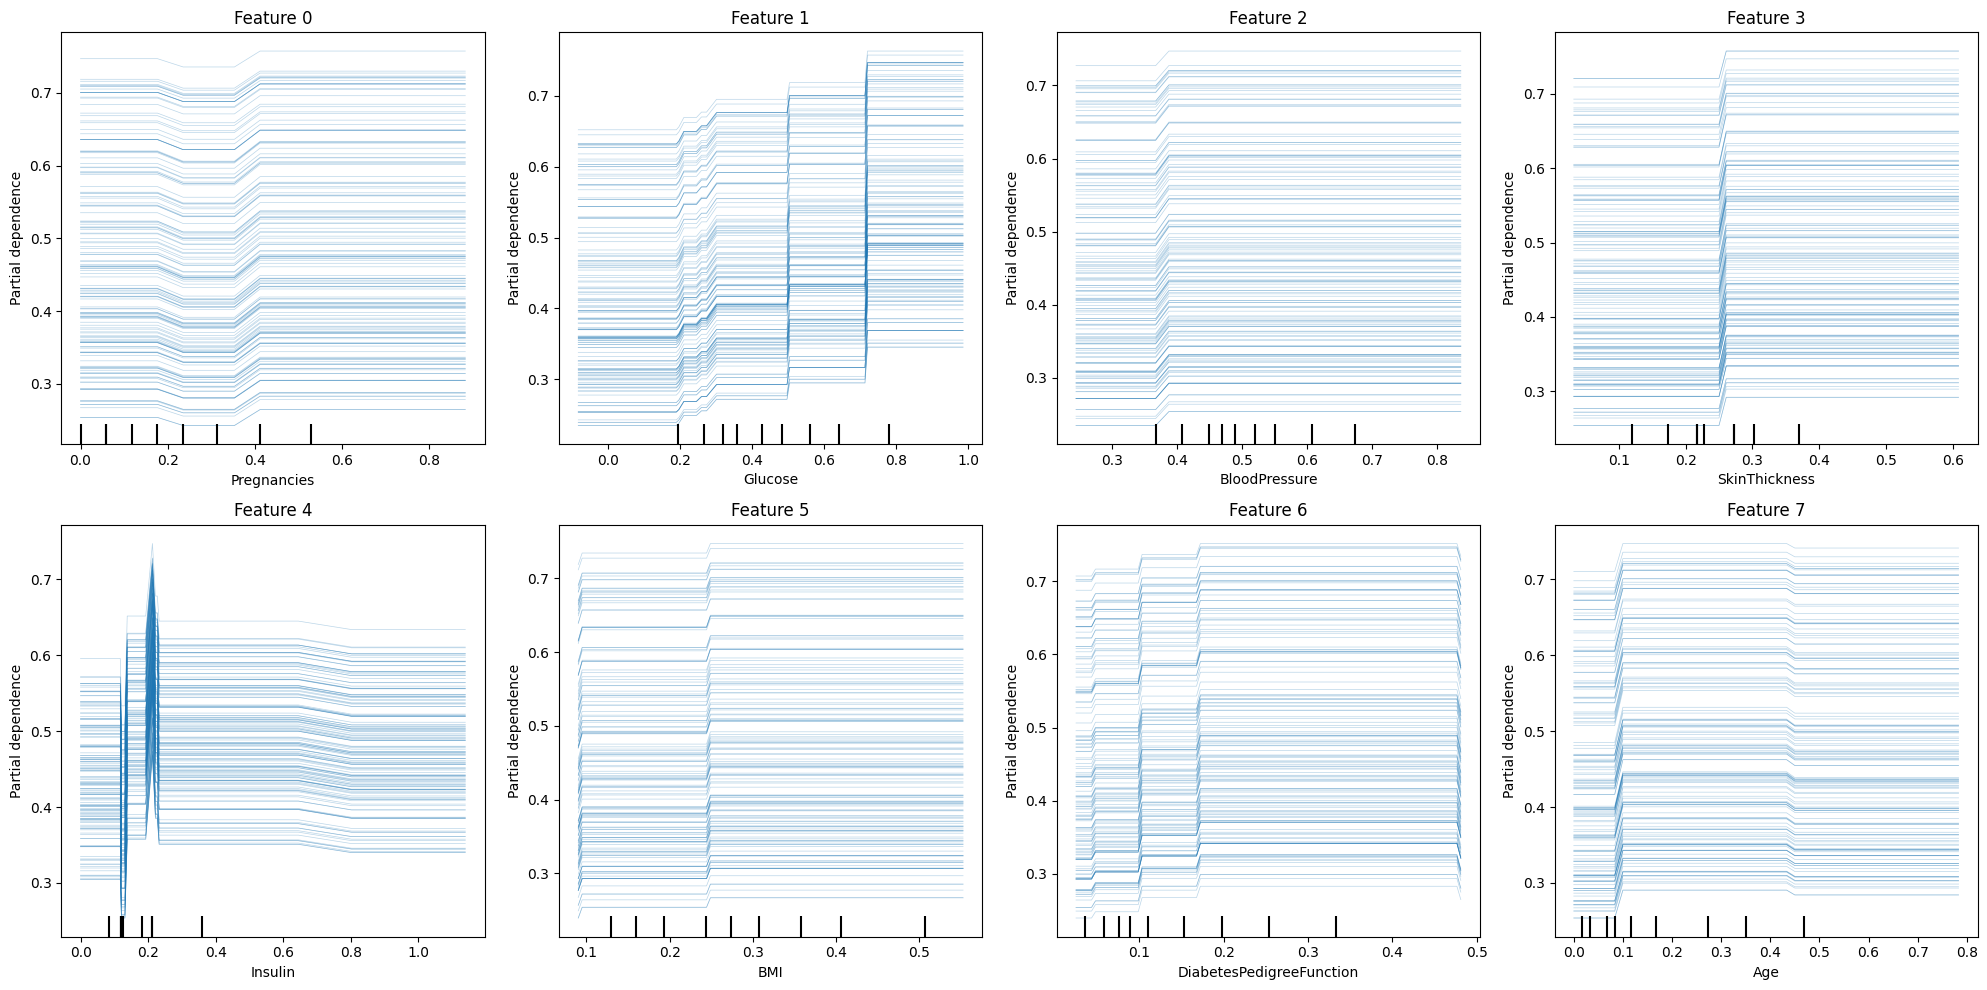

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i in range(X.shape[1]):
  feature = [i]
  target_class = 0
  PartialDependenceDisplay.from_estimator(adaboost, test_x_scaled, features=feature,feature_names=X.columns, target=target_class, kind='individual', ax=axes[i])
  axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

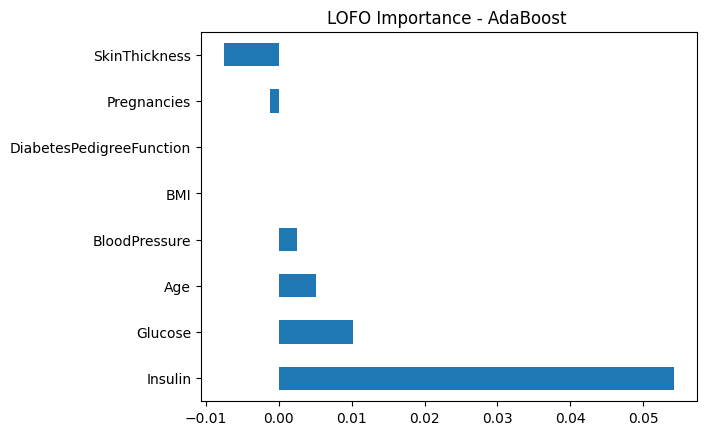

In [ ]:
baseline = cross_val_score(adaboost, train_x_scaled, train_y, cv=5).mean()

lofo_scores = {}
for col in X.columns:
    X_lofo = train_x_scaled_df.drop(columns=[col])
    score = cross_val_score(adaboost, X_lofo, train_y, cv=5).mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - AdaBoost ")
plt.show()

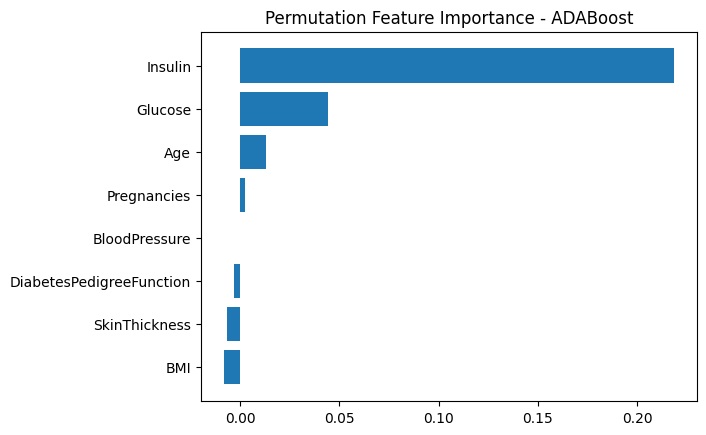

In [ ]:
result = permutation_importance(adaboost , test_x_scaled, test_y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - ADABoost")
plt.show()

In [ ]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(adaboost,train_x_scaled_df )

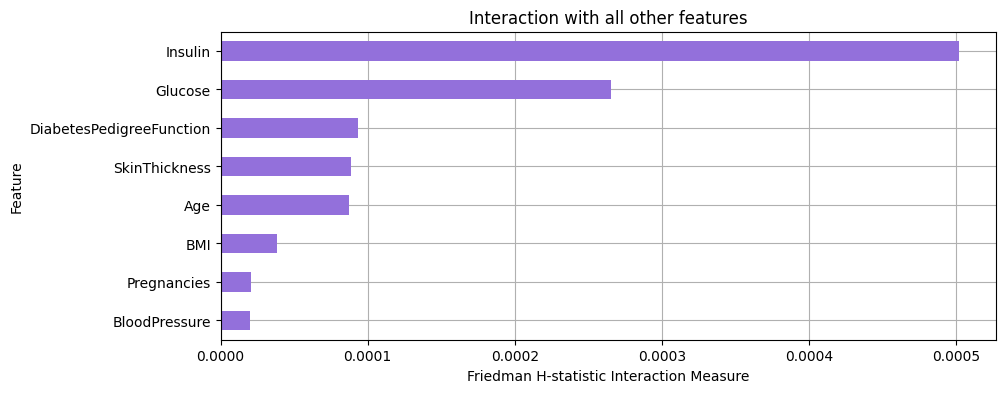

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

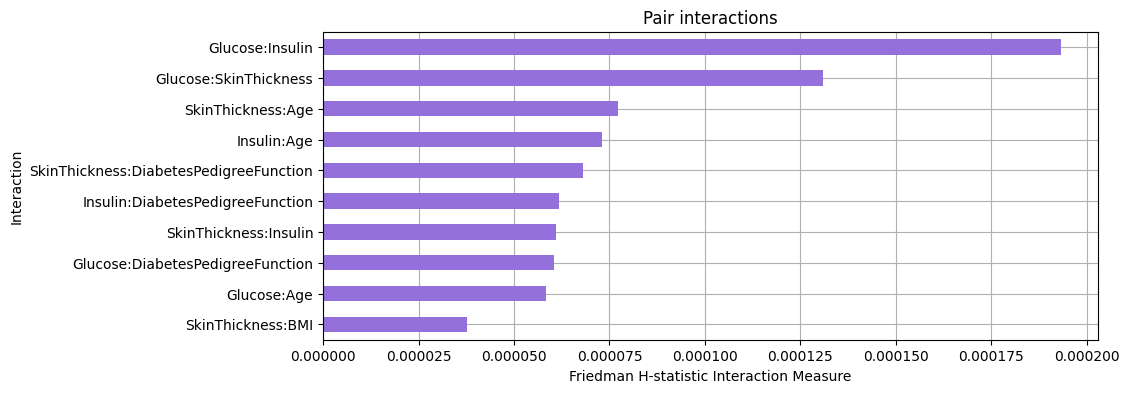

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)